Made by:
*   19CS10039: Kaushal Banthia
*   19CS10073: Rajat Bachhawat

### Importing the Libraries, Reading the Data and Visualising it

In [ ]:
import numpy as np
import numpy.matlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import calinski_harabasz_score, silhouette_score
from sklearn.metrics import adjusted_rand_score, fowlkes_mallows_score, homogeneity_score, normalized_mutual_info_score
from sklearn.model_selection import train_test_split

In [ ]:
data = pd.read_csv("/content/diabetes.csv")

# Dropping any rows (samples) with even one null value
data.dropna(how = 'any', inplace = True)
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 60.0 KB


In [ ]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


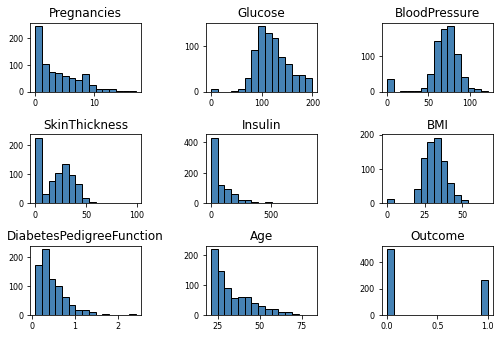

In [ ]:
data.hist(bins=15, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)    
plt.tight_layout(rect=(0, 0, 1.2, 1.2)) # plots the histograms

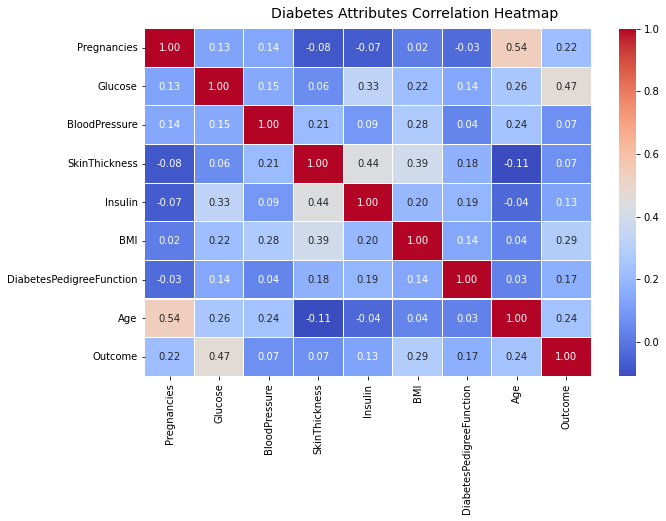

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
corr = data.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Diabetes Attributes Correlation Heatmap', fontsize=14) # plots the heatmap

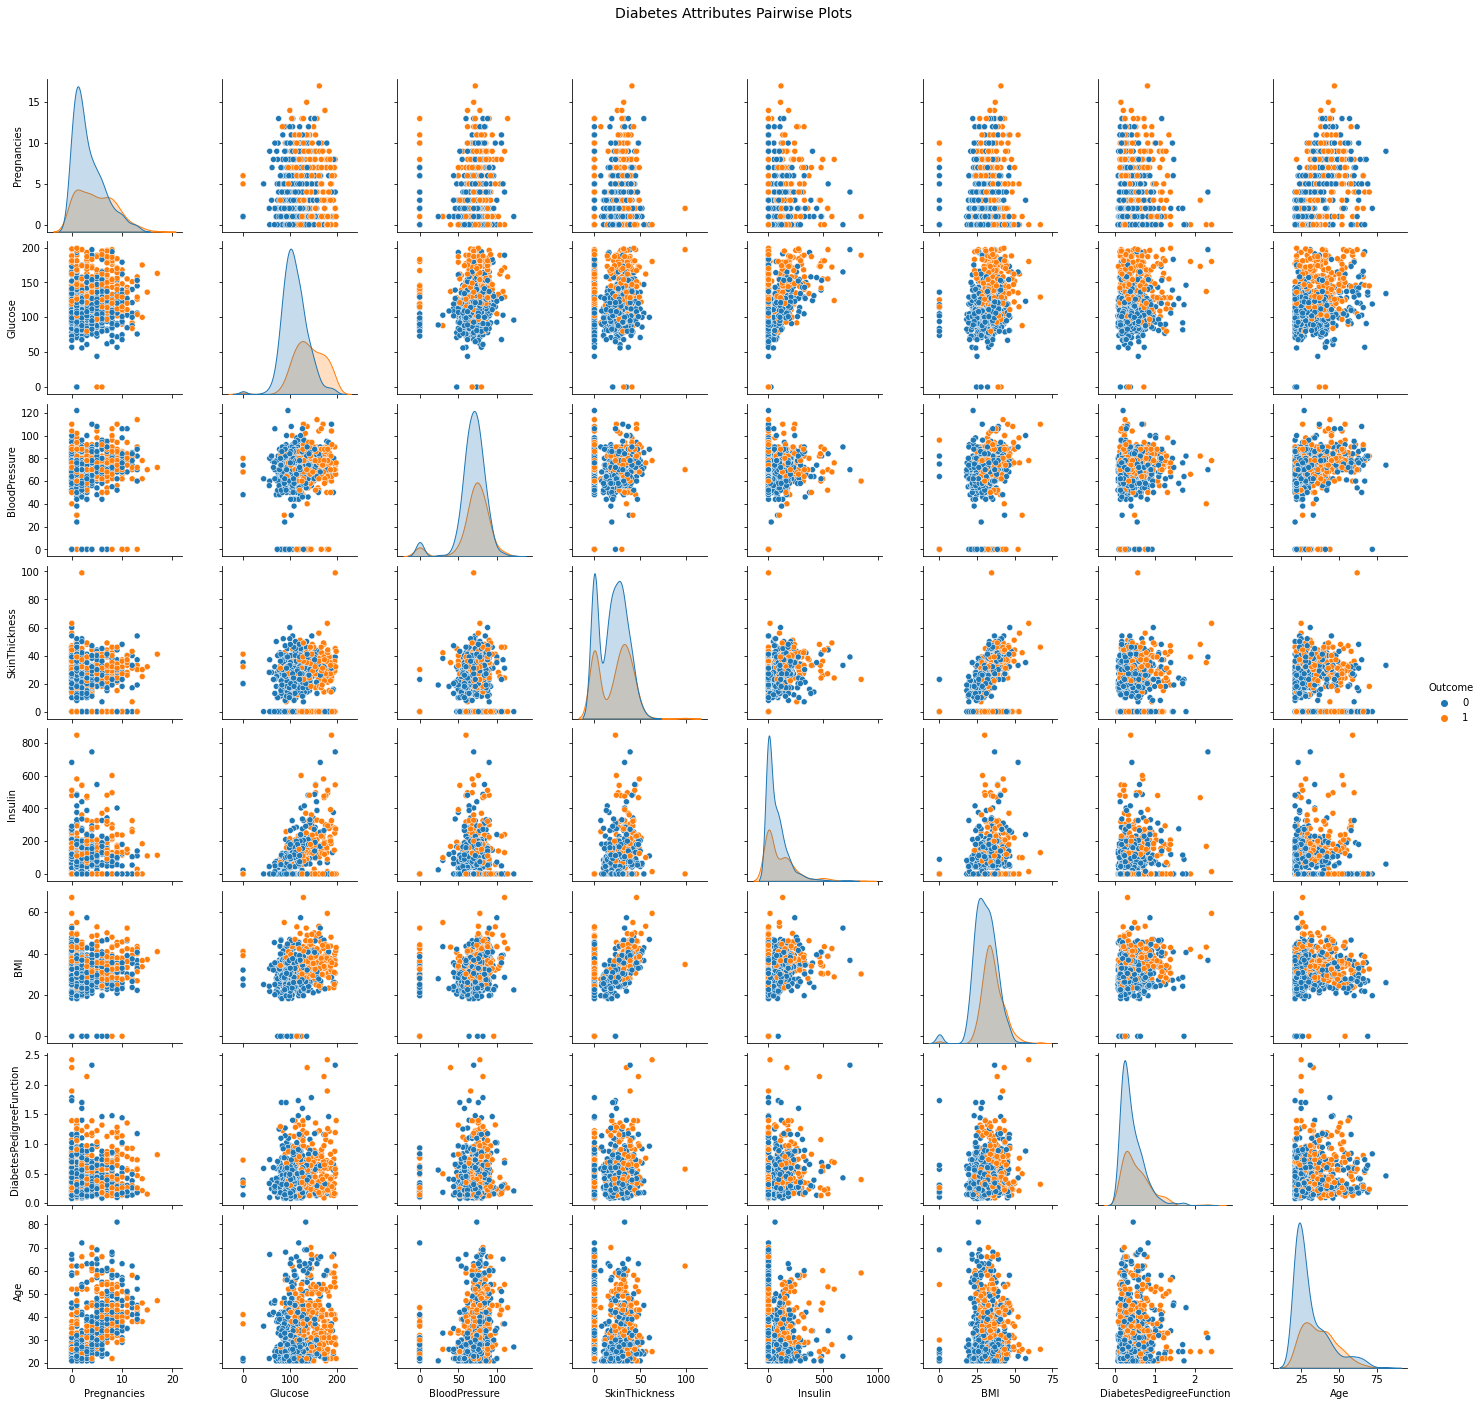

In [ ]:
pp = sns.pairplot(data[data.columns], hue='Outcome')
fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Diabetes Attributes Pairwise Plots', fontsize=14) # plots the pairplots

In [ ]:
# Separating the data labels from the data 
X = data.drop('Outcome', axis = 1)
y = data['Outcome']

# Normalisation of data
X = (X - X.min())/(X.max() - X.min())

### Helper Functions

#### Helper Function for Calculating Distance between 2 points

In [ ]:
def calc_distance(X1, X2):
  '''
  Returns the distance between 2 n-dimensional points

  Parameters: X1 - Array containing the first n - dimensional point
              X2 - Array containing the second n - dimensional point
  Returns: Distance between the 2 n-dimensional points
  '''
  return (sum((X1 - X2)**2))**0.5

Testing the Helper Function

In [ ]:
# X1 = np.array([2, 4, 3, 5, 0])
# X2 = np.array([2, 1, 9, 4, 1])
# print(calc_distance(X1, X2))

#### Helper Function for Assigning Cluster to the Data Points

In [ ]:
def assign_clusters(centroids, X):
  '''
  Assign cluster clusters based on closest centroid
  
  Parameters: centroids - Array of n - dimensional cluster centroids
              X - Array of n - dimensional data points
  Returns: clusters - Array containing assigned clusters to each of the data points
  '''
  clusters = []
  for i in range(X.shape[0]):
      distances = []
      for centroid in centroids:
          distances.append(calc_distance(centroid, X[i]))
      cluster = [z for z, val in enumerate(distances) if val==min(distances)]
      clusters.append(cluster[0])
  return np.array(clusters)

Testing the Helper Function

In [ ]:
# centroids = np.array([[1, 2], [4, 6], [8, 8]])
# X = np.array([[3, 4], [0, 3], [5, 3], [7, 7], [3, 0]])
# clusters = assign_clusters(centroids, X)
# print(clusters)

# plt.scatter(X[:, 0], X[:, 1])
# plt.scatter(centroids[:, 0], centroids[:, 1])

#### Helper Function for Calculating new Centroids

In [ ]:
def calc_centroids(clusters, X):
  '''
  Calculate new centroids based on each cluster's mean

  Parameters: clusters - Array containing assigned clusters to each of the data points
              X - Array of n - dimensional data points
  Returns: new_centroids - Array containing new n - dimensional cluster centroids
  '''
  new_centroids = []
  cluster_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])], axis=1)

  for c in set(cluster_df['cluster']):
      current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
      cluster_mean = current_cluster.mean(axis=0)
      new_centroids.append(cluster_mean)
  return np.array(new_centroids)

Testing the Helper Function

In [ ]:
# new_centroids = calc_centroids(clusters, X)
# print(new_centroids)

# plt.scatter(X[:, 0], X[:, 1])
# plt.scatter(new_centroids[:, 0], new_centroids[:, 1])

#### Helper Function for finding Variance within a Cluster

In [ ]:
def calc_centroid_variance(clusters, X):
  '''
  Calculate variance within each cluster

  Parameters: clusters - Array containing assigned clusters to each of the data points
              X - Array of n-dimensional data points
  Returns: sum_squares - Array containing sum of the squares of each cluster
  '''
  sum_squares = []
  cluster_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])], axis=1)
  for c in set(cluster_df['cluster']):
      current_cluster = cluster_df[cluster_df['cluster']==c][cluster_df.columns[:-1]]
      cluster_mean = current_cluster.mean(axis=0)
      mean_repmat = np.matlib.repmat(cluster_mean, current_cluster.shape[0],1)
      sum_squares.append(np.sum(np.sum((current_cluster - mean_repmat)**2)))
  return np.array(sum_squares)

Testing the Helper Function

In [ ]:
# print(calc_centroid_variance(clusters, X))

### Q1. Implementing K - Means

In [ ]:
# This is the class for the KMeans model
class Kmeans:
  def __init__(self, k = 2, n_iter = 100, metric = 'variance', initial_centroids = None):
    '''
    Initialises the class.

    Parameters: k - Number of clusters (Default = 2)
                n_iter - Number of iterations (Default = 100)
                metric - Metric used for scoring (Default = 'variance')
                initial_centroids - Array of initial centroud (Default = None)
    '''
    self.k = k
    self.n_iter = n_iter
    self.clusters = np.array([])
    self.cluster_y = {}
    self.centroids = np.array([])
    self.initial_centroids = initial_centroids
    self.X = np.array([])
    self.cluster_metric_array = np.array([])

    if metric == 'variance':
      self.metric = calc_centroid_variance
  
  def train(self, X):
    '''
    Trains the K-Means model on the given dataset

    Parameters: X - The dataset
    '''
    self.X = np.array(X)

    # Initialise any k random centroids if no initial centroids passed (Lloyd Algorithm)
    if self.initial_centroids is None:
      np.random.seed(2)
      self.initial_centroids = self.X[np.random.choice(self.X.shape[0], self.k, replace=False)]

    self.centroids = self.initial_centroids
    self.prev_centroids = self.initial_centroids
    self.clusters = assign_clusters(self.centroids, self.X)
    self.cluster_metric_array = [round(np.mean(self.metric(self.clusters, self.X)))]

    for i in range(self.n_iter):
      self.centroids = calc_centroids(self.clusters, self.X)
      self.clusters = assign_clusters(self.centroids, self.X)
      cluster_var = np.mean(self.metric(self.clusters, self.X))
      self.cluster_metric_array.append(cluster_var)

      if (self.centroids == self.prev_centroids).all():
        break
      else:
        self.prev_centroids = self.centroids

  def train_predict(self, X):
    '''
    Trains the K-Means model on the given dataset and then predicts the output on the dataset

    Parameters: X - The dataset
    '''
    self.train(X)
    return self.clusters

  def predict(self, X_test):
    '''
    Predicts the output on the dataset passed

    Parameters: X_test - The dataset
    '''
    X_test = np.array(X_test)
    cluster_pred = assign_clusters(self.centroids, X_test)
    return np.array(cluster_pred)

### Q2. Clustering Performance

In [ ]:
kmeans = Kmeans(k = 2) # Creating an object of the KMeans class
y_pred = kmeans.train_predict(X) # Getting the predictions

print("--- Clustering Performance using available ground truth ---\n")

print("Adjusted Rand Index:", adjusted_rand_score(y, y_pred))
print("Fowlkes Mallows Score:", fowlkes_mallows_score(y, y_pred))
print("Homogeneity Score:", homogeneity_score(y, y_pred))
print("Normalised Mutual Info Score:", normalized_mutual_info_score(y, y_pred))

print("\n--- Clustering Performance without using available ground truth ---\n")

print("Silhouette Score:", silhouette_score(X, y_pred))
print("Calinski Harabasz Score:", calinski_harabasz_score(X, y_pred))

--- Clustering Performance using available ground truth ---

Adjusted Rand Index: 0.10238136070253465
Fowlkes Mallows Score: 0.5972349586286805
Homogeneity Score: 0.05121587703671173
Normalised Mutual Info Score: 0.051736896303927755

--- Clustering Performance without using available ground truth ---

Silhouette Score: 0.26114611149614975
Calinski Harabasz Score: 237.11040774547635


### Q3. Finding most suitable K for the data

#### Implementation of Wang's Method of Cross Validation

In [ ]:
def wangs_cross_validation(X, num_clusters = 2, num_iter = 100, c = 15, m = 0.45):
  '''
  Function for calculating the average number of disagreements calculated by using Wang's Cross Validation technique.

  Parameters: X - Array of n-dimensional data points
              num_clusters - Number of clusters (Default = 2)
              num_iter - Number of iterations (Default = 100)
              m - Percentage size of S1 and S2 (Default = 0.45)
              c - Number of different permuatations of the data that we try (Default = 2)
              
  Returns: avg_disagreements - Average number of disagreements
  '''
  if m >= 0.5:
    print("Value of m should be < 0.5 as size of S3 cannot be 0")
    return 0

  print("Number of Samples in S1, S2 = {}, {}".format(int(len(X)*m),int(len(X)*m)))
  print("Number of Samples in S3 = {}".format(len(X) - 2*int(len(X)*m)))

  total_disagreements = 0
  
  for i in range(0,c):
    X_permuted = np.random.permutation(X)
    S1, S2, S3 = np.split(X_permuted, [int(len(X_permuted)*m), int(len(X_permuted)*2*m)])

    km1 = Kmeans(k = num_clusters, n_iter = num_iter)
    km1.train(S1)
    km2 = Kmeans(k = num_clusters, n_iter = num_iter)
    km2.train(S2)

    cluster_pred1 = km1.predict(S3)
    cluster_pred2 = km2.predict(S3)

    for i in range(0, len(S3)):
      for j in range(0, len(S3)):
        if(i == j):
          continue
        if (cluster_pred1[i] == cluster_pred1[j] and cluster_pred2[i] != cluster_pred2[j]) \
        or (cluster_pred1[i] != cluster_pred1[j] and cluster_pred2[i] == cluster_pred2[j]):
          total_disagreements += 1
  avg_disagreements = total_disagreements / c
  return avg_disagreements

#### Finding Silhouette Index, Calinski-Harabasz Score for different values of K 

In [ ]:
silhouette_score_for_each_k = []          # List for storing the Silhouette Scores for the different values of K
calinski_harabasz_score_for_each_k = []   # List for storing the Calinski Harabasz Scores for the different values of K
for k in range(2, 12):
  kmeans = Kmeans(k = k)
  y_pred = kmeans.train_predict(X)
  ss = silhouette_score(X, y_pred)
  print("k = {}: Silhouette Index = {}".format(k,ss))
  silhouette_score_for_each_k.append(ss)

  chs = calinski_harabasz_score(X, y_pred)
  print("k = {}: Calinsky-Harabasz Score = {}".format(k,chs))
  calinski_harabasz_score_for_each_k.append(chs)

k = 2: Silhouette Index = 0.26114611149614975
k = 2: Calinsky-Harabasz Score = 237.11040774547635
k = 3: Silhouette Index = 0.18529494139379218
k = 3: Calinsky-Harabasz Score = 190.6633765466752
k = 4: Silhouette Index = 0.17607099400698867
k = 4: Calinsky-Harabasz Score = 159.13420710843707
k = 5: Silhouette Index = 0.16896442986194252
k = 5: Calinsky-Harabasz Score = 137.1735372568265
k = 6: Silhouette Index = 0.1849168144613298
k = 6: Calinsky-Harabasz Score = 141.67802579631729
k = 7: Silhouette Index = 0.17016422543319573
k = 7: Calinsky-Harabasz Score = 130.5259948619837
k = 8: Silhouette Index = 0.1674812385162561
k = 8: Calinsky-Harabasz Score = 124.92916431984936
k = 9: Silhouette Index = 0.15641720695277356
k = 9: Calinsky-Harabasz Score = 115.89998150431356
k = 10: Silhouette Index = 0.16621796966756405
k = 10: Calinsky-Harabasz Score = 113.57776404656944
k = 11: Silhouette Index = 0.15024057827237247
k = 11: Calinsky-Harabasz Score = 105.65035310562304


#### Finding no. of disagreements using Wang's Method over different values of K

In [ ]:
wangs_cross_val_avg_disagreements_for_each_k = []  # List for storing the Average number of disagreements
                                                   # (calculated using Wang's cross validation technique) for the different values of K
for k in range(2, 12):
  ws = wangs_cross_validation(X, k)
  print("k = {}: Avg no. of disagreements = {}".format(k,ws))
  wangs_cross_val_avg_disagreements_for_each_k.append(ws)

Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 2: Avg no. of disagreements = 20.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 3: Avg no. of disagreements = 636.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 4: Avg no. of disagreements = 1852.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 5: Avg no. of disagreements = 1362.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 6: Avg no. of disagreements = 1314.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 7: Avg no. of disagreements = 926.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 8: Avg no. of disagreements = 750.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 9: Avg no. of disagreements = 908.0
Number of Samples in S1, S2 = 345, 345
Number of Samples in S3 = 78
k = 10: Avg no. of disagreements = 952.0
Number of Samples in S1, 

#### Plots for the various indices used

Silhouette Index vs Number Of Clusters

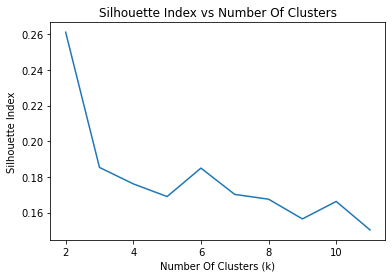

In [ ]:
plt.plot(range(2, 12), silhouette_score_for_each_k)
plt.xlabel("Number Of Clusters (k)")
plt.ylabel("Silhouette Index")
plt.title("Silhouette Index vs Number Of Clusters")
plt.show()

Calinsky-Harabasz Score vs Number Of Clusters

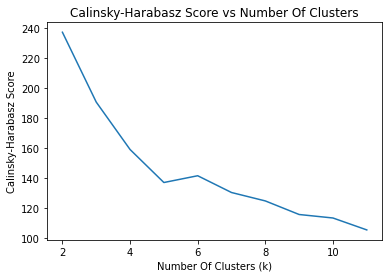

In [ ]:
plt.plot(range(2, 12), calinski_harabasz_score_for_each_k)
plt.xlabel("Number Of Clusters (k)")
plt.ylabel("Calinsky-Harabasz Score")
plt.title("Calinsky-Harabasz Score vs Number Of Clusters")
plt.show()

Wang's Method of Cross Validation vs Number of Clusters

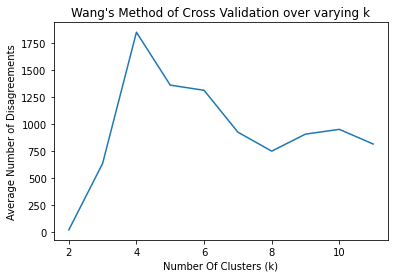

In [ ]:
plt.plot(range(2, 12), wangs_cross_val_avg_disagreements_for_each_k)
plt.xlabel("Number Of Clusters (k)")
plt.ylabel("Average Number of Disagreements")
plt.title("Wang's Method of Cross Validation over varying k")
plt.show()

### Q4. Analysing the stability of the clustering

#### Implementing Test A

Pseudo-code

```
1. select K points (either randomly or using a heuristic) as the initial centroids of the *clusters*
2. split remaining data into 2 parts randomly (80:20) ratio
3. apply k-means on training data with K-random points selected in step-1
4. label test data using k-centroids.
5. use metrics NMI, ARI, etc. in test data to understand clustering accuracy
6. repeat 2-5 at least 50 times and report average metric
```



In [ ]:
def testA(test_iter, X, y, k, num_iter = 50, heuristic = None):
  k_random_initial_centroids = []
  X = np.array(X)
  y = np.array(y)

  if heuristic is None:
    np.random.seed(test_iter)
    centroid_indices = np.random.choice(X.shape[0], k, replace=False)
    k_random_initial_centroids = X[centroid_indices]
    np.delete(X, centroid_indices, 0)
    np.delete(y, centroid_indices, 0)
  
  elif heuristic == "kmeans++":
    np.random.seed(test_iter)
    centroid_indices = list(np.random.choice(X.shape[0], 1, replace=False))
    
    num_centroids = 1
    while num_centroids < k:
      dist_list = []
      
      for i in range(0, X.shape[0]):
        min_dist = 1e18
        for c_id in centroid_indices:
          dist = calc_distance(X[i],X[c_id])
          dist = min(dist, min_dist)
        dist_list.append(min_dist)
      
      dist_list = np.array(dist_list)
      next_centroid_index = np.argmax(dist_list)
      centroid_indices.append(next_centroid_index)
      num_centroids += 1
    
    k_random_initial_centroids = X[centroid_indices]
    np.delete(X, centroid_indices, 0)
    np.delete(y, centroid_indices, 0)

  avg_adjusted_rand_score = 0
  avg_fowlkes_mallows_score = 0
  avg_homogeneity_score = 0
  avg_normalized_mutual_info_score = 0

  for i in range(0, num_iter):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
    kmeans_model = Kmeans(k = k, initial_centroids = k_random_initial_centroids)
    kmeans_model.train(X_train)
    y_pred = kmeans_model.predict(X_test)

    avg_homogeneity_score += homogeneity_score(y_test, y_pred)
    avg_adjusted_rand_score += adjusted_rand_score(y_test, y_pred)
    avg_normalized_mutual_info_score += normalized_mutual_info_score(y_test, y_pred)
    avg_fowlkes_mallows_score += fowlkes_mallows_score(y_test, y_pred)
  
  avg_adjusted_rand_score /= num_iter
  avg_fowlkes_mallows_score /= num_iter
  avg_homogeneity_score /= num_iter
  avg_normalized_mutual_info_score /= num_iter

  return avg_adjusted_rand_score, avg_fowlkes_mallows_score, avg_homogeneity_score, avg_normalized_mutual_info_score

#### Part a. Checking the stability of the clustering over 50 **random** initializations of the initial K centroids
We do this without using any heuristic to choose the k initial centroids

In [ ]:
# All the different metrics are calculated here

num_iter = 50
avg_adjusted_rand_score_for_each_iter = []
avg_fowlkes_mallows_score_for_each_iter = []
avg_homogeneity_score_for_each_iter = []
avg_normalized_mutual_info_score_for_each_iter = []

for i in range(0, num_iter):
  print("Run #{} of Test-A".format(i+1))
  avg_adjusted_rand_score, avg_fowlkes_mallows_score, avg_homogeneity_score, avg_normalized_mutual_info_score = testA(i, X, y, 2, 50)
  
  print("ARI = {} FM = {} HS = {} NMI = {}".format(avg_adjusted_rand_score, avg_fowlkes_mallows_score, avg_homogeneity_score, avg_normalized_mutual_info_score))
  
  avg_adjusted_rand_score_for_each_iter.append(avg_adjusted_rand_score)
  avg_fowlkes_mallows_score_for_each_iter.append(avg_fowlkes_mallows_score)
  avg_homogeneity_score_for_each_iter.append(avg_homogeneity_score)
  avg_normalized_mutual_info_score_for_each_iter.append(avg_normalized_mutual_info_score)

Run #1 of Test-A
ARI = 0.10337316867199627 FM = 0.5951275402184559 HS = 0.05798582210096595 NMI = 0.057940963758233405
Run #2 of Test-A
ARI = 0.10293419470789501 FM = 0.5932143610190918 HS = 0.057305798958837605 NMI = 0.05758410278679448
Run #3 of Test-A
ARI = 0.09749820020003531 FM = 0.5911735539335127 HS = 0.05400709384234514 NMI = 0.05455858796946253
Run #4 of Test-A
ARI = 0.09238224301334334 FM = 0.5930393323213643 HS = 0.048978468404444225 NMI = 0.049459036916031096
Run #5 of Test-A
ARI = 0.09655308712499336 FM = 0.5960959479344714 HS = 0.05079574279112565 NMI = 0.05111890576133952
Run #6 of Test-A
ARI = 0.09665712101765182 FM = 0.597534795686126 HS = 0.050470920586553586 NMI = 0.050988438946424575
Run #7 of Test-A
ARI = 0.10162054506714872 FM = 0.5982533764281116 HS = 0.054557048930917854 NMI = 0.05494220748067086
Run #8 of Test-A
ARI = 0.09710453558748652 FM = 0.5932235887391445 HS = 0.052692438074661084 NMI = 0.05339289960886258
Run #9 of Test-A
ARI = 0.10074674329988122 FM = 0

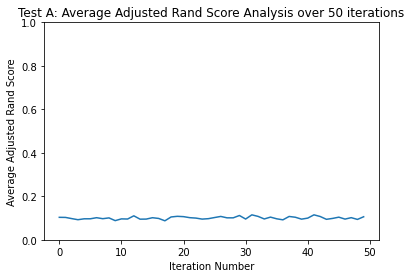

Mean over 50 Iterations = 0.1004255833999036
Standard Dev. over 50 Iterations = 0.006164274523057471


In [ ]:
# Average Adjusted Rand Score is plotted here

plt.plot(range(0, num_iter), avg_adjusted_rand_score_for_each_iter)
plt.title("Test A: Average Adjusted Rand Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Adjusted Rand Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(avg_adjusted_rand_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(avg_adjusted_rand_score_for_each_iter)))

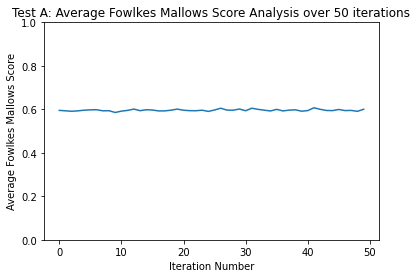

Mean over 50 Iterations = 0.595965424664374
Standard Dev. over 50 Iterations = 0.004014911135917208


In [ ]:
# Average Fowlkes Mallows Score Analysis is plotted here

plt.plot(range(0, num_iter), avg_fowlkes_mallows_score_for_each_iter)
plt.title("Test A: Average Fowlkes Mallows Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Fowlkes Mallows Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(avg_fowlkes_mallows_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(avg_fowlkes_mallows_score_for_each_iter)))

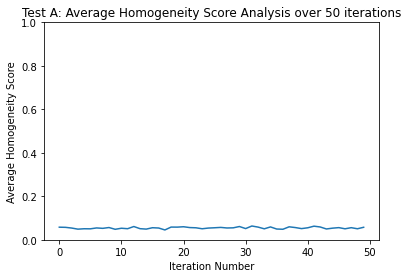

Mean over 50 Iterations = 0.05455174497470611
Standard Dev. over 50 Iterations = 0.0040745908856798544


In [ ]:
# Average Homogeneity Score Analysis is plotted here

plt.plot(range(0, num_iter), avg_homogeneity_score_for_each_iter)
plt.title("Test A: Average Homogeneity Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Homogeneity Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(avg_homogeneity_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(avg_homogeneity_score_for_each_iter)))

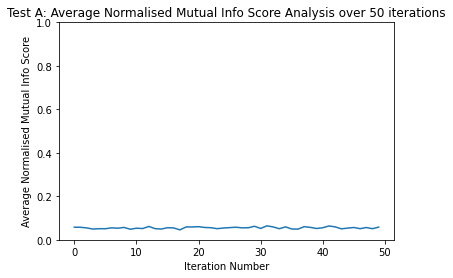

Mean over 50 Iterations = 0.055042325142949586
Standard Dev. over 50 Iterations = 0.0041644724736847605


In [ ]:
# Average Normalised Mutual Info Score Analysis is plotted here

plt.plot(range(0, num_iter), avg_normalized_mutual_info_score_for_each_iter)
plt.title("Test A: Average Normalised Mutual Info Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Normalised Mutual Info Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(avg_normalized_mutual_info_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(avg_normalized_mutual_info_score_for_each_iter)))

#### Part b. Checking the stability of the clustering over 50 heuristic based initializations of the initial K centroids 
We do this using the K-Means++ initialization technique as the heuristic

In [ ]:
# All the different metrics are calculated here

num_iter = 50
heuristic_avg_adjusted_rand_score_for_each_iter = []
heuristic_avg_fowlkes_mallows_score_for_each_iter = []
heuristic_avg_homogeneity_score_for_each_iter = []
heuristic_avg_normalized_mutual_info_score_for_each_iter = []

for i in range(0, num_iter):
  print("Run #{} of Test-A".format(i+1))
  avg_adjusted_rand_score, avg_fowlkes_mallows_score, avg_homogeneity_score, avg_normalized_mutual_info_score = testA(i, X, y, 2, 50, "kmeans++")
  
  print("ARI = {} FM = {} HS = {} NMI = {}".format(avg_adjusted_rand_score, avg_fowlkes_mallows_score, avg_homogeneity_score, avg_normalized_mutual_info_score))
  
  heuristic_avg_adjusted_rand_score_for_each_iter.append(avg_adjusted_rand_score)
  heuristic_avg_fowlkes_mallows_score_for_each_iter.append(avg_fowlkes_mallows_score)
  heuristic_avg_homogeneity_score_for_each_iter.append(avg_homogeneity_score)
  heuristic_avg_normalized_mutual_info_score_for_each_iter.append(avg_normalized_mutual_info_score)

Run #1 of Test-A
ARI = 0.10419585869644615 FM = 0.5963736334740755 HS = 0.057721456661939195 NMI = 0.057787994690210114
Run #2 of Test-A
ARI = 0.10217549163491793 FM = 0.5929771264423873 HS = 0.056708363669561314 NMI = 0.05699584600051147
Run #3 of Test-A
ARI = 0.09723266207720313 FM = 0.5912812253343928 HS = 0.053717410297181384 NMI = 0.05428843554382821
Run #4 of Test-A
ARI = 0.09352695216527977 FM = 0.5937706798626529 HS = 0.04958984329739389 NMI = 0.050095064499114966
Run #5 of Test-A
ARI = 0.0970446464107583 FM = 0.5958143015328811 HS = 0.051327461908265475 NMI = 0.05160279517736863
Run #6 of Test-A
ARI = 0.09636105206407372 FM = 0.5968881393582574 HS = 0.050309668364411204 NMI = 0.05076366406000847
Run #7 of Test-A
ARI = 0.10092893579663084 FM = 0.5977914751412157 HS = 0.054153145316827155 NMI = 0.05451238939931736
Run #8 of Test-A
ARI = 0.09687477643651164 FM = 0.5930070882550289 HS = 0.05257696431632807 NMI = 0.05327146927375942
Run #9 of Test-A
ARI = 0.10097738075357263 FM = 0

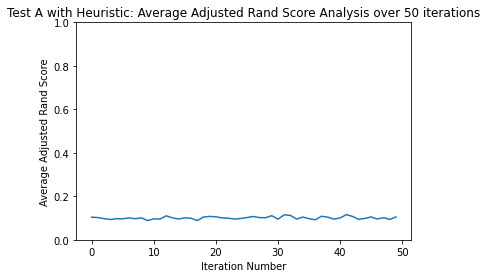

Mean over 50 Iterations = 0.10072017486543272
Standard Dev. over 50 Iterations = 0.006168386810223996


In [ ]:
# Average Adjusted Rand Score Analysis is plotted here

plt.plot(range(0, num_iter), heuristic_avg_adjusted_rand_score_for_each_iter)
plt.title("Test A with Heuristic: Average Adjusted Rand Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Adjusted Rand Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(heuristic_avg_adjusted_rand_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(heuristic_avg_adjusted_rand_score_for_each_iter)))

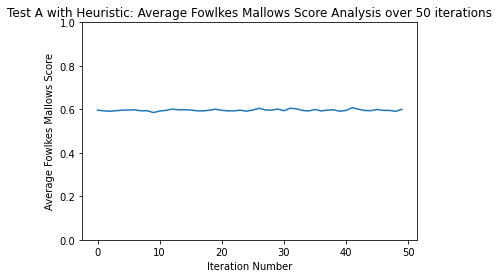

Mean over 50 Iterations = 0.5960867910749468
Standard Dev. over 50 Iterations = 0.004041973536068245


In [ ]:
# Average Fowlkes Mallows Score Analysis is plotted here

plt.plot(range(0, num_iter), heuristic_avg_fowlkes_mallows_score_for_each_iter)
plt.title("Test A with Heuristic: Average Fowlkes Mallows Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Fowlkes Mallows Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(heuristic_avg_fowlkes_mallows_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(heuristic_avg_fowlkes_mallows_score_for_each_iter)))

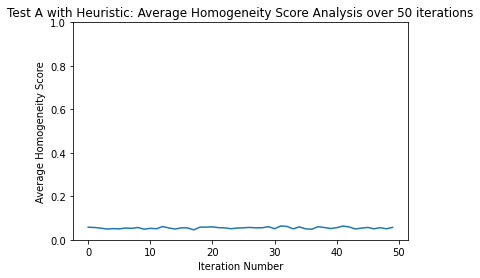

Mean over 50 Iterations = 0.05472562346872939
Standard Dev. over 50 Iterations = 0.004043816907642185


In [ ]:
# Average Homogeneity Score Analysis is plotted here

plt.plot(range(0, num_iter), heuristic_avg_homogeneity_score_for_each_iter)
plt.title("Test A with Heuristic: Average Homogeneity Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Homogeneity Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(heuristic_avg_homogeneity_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(heuristic_avg_homogeneity_score_for_each_iter)))

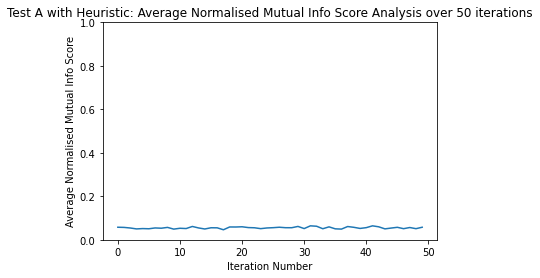

Mean over 50 Iterations = 0.05521365421925044
Standard Dev. over 50 Iterations = 0.004137469059202788


In [ ]:
# Average Normalised Mutual Info Score Analysis is plotted here

plt.plot(range(0, num_iter), heuristic_avg_normalized_mutual_info_score_for_each_iter)
plt.title("Test A with Heuristic: Average Normalised Mutual Info Score Analysis over {} iterations".format(num_iter))
plt.xlabel("Iteration Number")
plt.ylabel("Average Normalised Mutual Info Score")
ax = plt.gca()
ax.set_ylim([0.0, 1.0])
plt.show()
print("Mean over {} Iterations = {}".format(num_iter, np.mean(heuristic_avg_normalized_mutual_info_score_for_each_iter)))
print("Standard Dev. over {} Iterations = {}".format(num_iter, np.std(heuristic_avg_normalized_mutual_info_score_for_each_iter)))